In [6]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()
import rosbag_pandas
import pandas as pd
import matplotlib.pyplot as plt
import easygui
import rosbag
import json
import numpy as np
import cPickle as pkl
import time
import seaborn as sns
import datetime as dt
import fnmatch
import os
import bokeh.palettes as bp
from bokeh.layouts import column
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead, Div
from bokeh.io import export_png
from bokeh.plotting import figure, output_file, show, gridplot,save
from datetime import datetime

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)
    
def pickler( obj, path):
    """
    Pickle a Python object
    """
    with open(path, "wb") as pfile:
        pkl.dump(obj, pfile)

def depickler( path):
    """
    Extracts a pickled Python object and returns it
    """
    with open(path, "rb") as pfile:
        data = pkl.load(pfile)
    return data
import os

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths  # Self-explanatory.

# Run the above function and store its results in a variable.   
full_file_paths = get_filepaths("/Users/johnny/Desktop/TEST")

In [7]:

def bokehPlot(df, case, parameters, fig=None,
              TOOLS="pan,crosshair,wheel_zoom\
              ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
              x_range=(506, 526), y_range=(506, 526),
              output_backend="webgl", plot_width=500, plot_height=500,
              s=6, xc=513, yc=505,
              xw=20, yw=20, xi=506., yi=503.,
              showPlot=True, title=None, addOdour=True,
              addSmallTit=True, addStart=True, addArrow=True,reallign=True):
    dfc = df[df.trajectory__case == case]
    x = dfc.trajectory__pPos_x
    y = dfc.trajectory__pPos_y
    h = np.deg2rad(dfc.trajectory__pOri_x)

    if 'haw' in parameters['fly']:
        dfcv = dfc.trajectory__valve2
        dfcvP = dfc.trajectory__valve1 #other odour incase of error in gui


    elif 'apple' in parameters['fly']:
        dfcv = dfc.trajectory__valve1
        dfcvP = dfc.trajectory__valve2 #other odour incase of error in gui
        
    else :#likely mosquito or hoverfl
        dfcv = dfc.trajectory__valve1
        dfcvP = dfc.trajectory__valve2 #other odour incase of error in gui

    ox = dfc[dfcv == True].trajectory__pPos_x
    oy = dfc[dfcv == True].trajectory__pPos_y
    
    oxP = dfc[dfcvP == True].trajectory__pPos_x
    oyP = dfc[dfcvP == True].trajectory__pPos_y

    
    #     opf=dfc[dfc.trajectory__valve1==True].trajectory__pOri_x

    #     import matplotlib as mpl
    #     colors = [
    #         "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(opf))
    #     ]


    try:
        cm = bp.viridis(max(parameters['odourQuad']) + 1)
        fc = cm[parameters["odourQuad"][case]]
    except TypeError:
        fc = bp.viridis(10)[5]

    if not addSmallTit:
        title = ''

    if fig is None:
        fig = figure(tools=TOOLS, x_range=x_range, y_range=y_range, output_backend=output_backend,
                     plot_width=plot_width, plot_height=plot_height,
                     active_scroll='wheel_zoom', title=title)

    fig.title.align = 'center'
    fig.title.text_font_size = '14pt'

    r = 2
    xs = parameters['playerInitPos'][0]
    ys = parameters['playerInitPos'][1]
    theta = parameters['windQuadOpen'][case] + 180
    if reallign:
        xoffs = xs - 513
        yoffs = ys - 513
    else:
        xoffs=0
        yoffs=0
    # Pos and heading of fly
    fig.triangle(x - xoffs, y - yoffs, size=s, angle=h, fill_alpha=0.5, line_color=None)

    if addOdour:
        # circle at odour pos, with pf encoded in color
        fig.circle(ox- xoffs, oy- yoffs, size=2 * s, fill_alpha=0.8, line_color=None, fill_color=fc)
        fig.circle(oxP- xoffs, oyP- yoffs, size=2 * s, fill_alpha=0.8, line_color=None, fill_color=(255,0,0))

        
    if addStart:
        # triangle at init pos
        fig.triangle(parameters['playerInitPos'][0], parameters['playerInitPos'][1],
                     size=3 * s, angle=0, fill_alpha=0.9, line_color=None, color='firebrick')

    # arrow

    if parameters["windQuad"][case] == -3:
        lw = 0
        la = 0.1
    elif parameters["windQuad"][case] == -2:
        lw = 4
        la = 1
    else:
        lw = 10
        la = 1
    # print 'le is',lw
    if addArrow:
        fig.add_layout(Arrow(end=VeeHead(size=20), line_color="red", line_alpha=la,

                             x_start=xs, y_start=ys, line_width=lw,
                             x_end=xs + r * np.cos(np.deg2rad(theta)), y_end=ys + r * np.sin(np.deg2rad(theta))))

    return fig

def bokehQuadPlot(df,parameters,path=None, tr=None,tl=None,bl=None,br=None,
                  TOOLS="pan,crosshair,wheel_zoom,box_zoom,\
                  reset,box_select,lasso_select,undo,redo,save",
                  x_range=(506,526), y_range=(506,526),plot_width=1000, 
                  plot_height=1000,
                 output_backend="webgl",showPlot=False,exposeReturn=False,
                 addBigTit=True,addSmallTit=True, 
                  addArrow=True,addStart=True,addOdour=True,decimate=1):
    
    '''
    plot a single df
    '''
    df=df.ix[::decimate]
    if path is None:
        path = 'blank'
    # output to static HTML file (with CDN resources)
    output_file(path+".html", title="Trajectory Quad", mode="cdn")


    # create a new plot with the tools above, and explicit ranges
    w=500
    h=500 
    s=6
    xc=516
    yc=513
    xw=20
    yw=20
    xi=xc-xw/2.
    yi=yc-yw/2.

    
    
    ls=parameters['loadingString']
    wq=parameters['windQuad']
    oq=parameters['odourQuad']
    wqo=parameters['windQuadOpen']
    
    def quadTitGen(quad,ls=ls,wq=wq,oq=oq,wqo=wqo):
        tit='odour : '+str(oq[quad])+'\t wind : '+str(wq[quad])+'\t windDir : '+str(wqo[quad])
#         tit='ls : '+str(ls)+'\t odour : '+str(oq[quad])+'\t wind : '+str(wq[quad])+'\t windDir : '+str(wqo[quad])

        return tit
    
    
    bl=bokehPlot(df,2,parameters,TOOLS=TOOLS,title=quadTitGen(2),
                 fig=bl,addSmallTit=addSmallTit,addStart=addStart,
                 addArrow=addArrow,addOdour=addOdour
                 ,x_range=x_range, y_range=y_range)
    tr=bokehPlot(df,0,parameters,x_range=bl.x_range, y_range=bl.y_range,TOOLS=TOOLS,title=quadTitGen(0),
                 fig=tr,addSmallTit=addSmallTit,addStart=addStart,
                 addArrow=addArrow,addOdour=addOdour)
    tl=bokehPlot(df,1,parameters,x_range=bl.x_range, y_range=bl.y_range,TOOLS=TOOLS,title=quadTitGen(1),
                 fig=tl,addSmallTit=addSmallTit,addStart=addStart
                 ,addArrow=addArrow,addOdour=addOdour)
    br=bokehPlot(df,3,parameters,x_range=bl.x_range, y_range=bl.y_range,TOOLS=TOOLS,title=quadTitGen(3),
                 fig=br,addSmallTit=addSmallTit,addStart=addStart,
                 addArrow=addArrow,addOdour=addOdour)


    p = gridplot([[tl, tr], [bl, br]])
#     export_png(p, filename=path+".png")
    if addBigTit:
        p=column(Div(text=path.split('/')[-1]),p)
    
    if exposeReturn:#if you want access to all plots
        return p,tr,tl,bl,br
    else:
            
        if showPlot:
            show(p)
        else:
            save(p)

        return p,None,None,None,None


def pickle2df(path=None, hdf5=False, defaultPath="/home/rhagoletis/catkin/src/World/bags/"):
    '''Load a dataframe from pickle
    
    returns:
    df, parameters, path
    '''

    if hdf5:
        filetypes = ["*.h5"]
    else:
        filetypes = ["*dfpickle"]

    if path is None:
        path = easygui.fileopenbox(title="Bags to Dataframes"
                                   , default=defaultPath,
                                   multiple=False, filetypes=filetypes)

    # print path, "\n"
    #     for path in paths:
    #     print "\n\ncurrentl;y analysisnh",path

    # picklepath=path+"_df.pickle"

    if hdf5:
        df = pd.read_hdf(path)
        fnjson = '.'.join(path.split('.')[:-2]) + '.json'
        with open(fnjson) as f:
            parameters = (json.load(f))['parameters']
            # print parameters

    else:
        data = depickler(path)
        parameters = data['metadata']['parameters']
        df = data["df"]

    df.parameters = parameters

    return df, parameters, path

# def pickle2df(path=None):
#     '''Load a dataframe from pickle'''
#     defaultPath="/home/rhagoletis/catkin/src/World/bags/"
#     if path is None:
#         path=easygui.fileopenbox(title="Bags to Dataframes"
#                                   ,default=defaultPath,
#                                   multiple=False,filetypes=["*.dfpickle"])
        
# #     print path, "\n"
# #     for path in paths:
# #     print "\n\ncurrentl;y analysisnh",path
#     # picklepath=path+"_df.pickle"
#     data=depickler(path)
#     df=data["df"]
#     parameters=data['metadata']['parameters']

#     return df,parameters,path




def pickle2bokeh(path=None,showPlot=True,exposeReturn=False,tr=None,tl=None,bl=None,br=None,
                 addBigTit=True,addSmallTit=True,addArrow=True,addStart=True,addOdour=False,
                 x_range=(506,526), y_range=(506,526),decimate=1):
    
    df,parameters,path=pickle2df(path=path)
    try:
        plot,tr,tl,bl,br=bokehQuadPlot(df=df,parameters=parameters,path=path,showPlot=showPlot,
                                       exposeReturn=exposeReturn,tr=tr,tl=tl,bl=bl,br=br,
                                       addBigTit=addBigTit,addSmallTit=addSmallTit, addArrow=addArrow,
                                       addStart=addStart,addOdour=addOdour,
                                       x_range=x_range, y_range=y_range,decimate=decimate)
    except SyntaxError as e:
        print "\n\n\n Exception",e
        return None,None,None,None
    
    if exposeReturn:#if you want access to all plots
        return plot,df,parameters,path,tr,tl,bl,br
    else:
        return plot,df,parameters,path


def fileList(foldPath,included=['*bag_df.pickle'],excluded=[]):

    
    matches = []
    for root, dirnames, filenames in os.walk(foldPath):
        
        for include in included:
            for filename in fnmatch.filter(filenames, include):
                toKeep=True
                
                for exclude in excluded:
                    if exclude in filename:
                        toKeep=False
                    
                if toKeep:
                    matches.append(os.path.join(root, filename))
    matches.sort()
    return matches


def pickleDir2bokeh(foldPath=None,showPlot=False,
                    addBigTit=True,addSmallTit=True,addArrow=True,
                    addStart=True,addOdour=False,
                    x_range=(506, 526), y_range=(506, 526),
                   defaultPath='/media/rhagoletis/6db8b2b2-ebe2-4555-9b79-93b10ef9dec31/agg/odour+wind/',):
    tstart = datetime.now()

    if foldPath is None:
        foldPath= easygui.diropenbox(    default=defaultPath)
    
    matches=fileList(foldPath,included=['*bag_df.pickle'],excluded=['pf'])


    matches.sort(reverse=True)
    print matches
    
    i=1 #file progress index
    for path in matches:
        
        tic()
        plot, df,parameters,path =pickle2bokeh(path,showPlot=showPlot,
                          addBigTit=addBigTit,addSmallTit=addSmallTit,
                           addArrow=addArrow,addStart=addStart,
                          x_range=x_range, y_range=y_range,addOdour=addOdour)

#         df,parameters=pickle2df(path)
        
#         try:
#             bokehQuadPlot(df=df,parameters=parameters,path=path)
#         except Exception as e:
#             print "\n\n\n Exception",e
#             pass
        
        print('\n\n Currently anal on {}. \n It is {} / {} file'.format(path.split('/')[-1], i,len(matches)))

        i+=1
        toc()
    
    tend = datetime.now()
    print "Total time",tend - tstart

    

# def dfDir2bokeh():
    
#     from datetime import datetime

#     tstart = datetime.now()



#     foldPath= easygui.diropenbox(    default="/home/rhagoletis/catkin/src/World/bags/")
#     matches = []
#     for root, dirnames, filenames in os.walk(foldPath):
#         for filename in fnmatch.filter(filenames, '*traj.bag_df.pickle'):
#             if 'pf' in filename:
#                 continue
#             matches.append(os.path.join(root, filename))
#     matches.sort(reverse=True)
#     print matches
    
#     i=1
#     for path in matches:
        
#         tic()
        
# #         df,parameters=pickle2bokeh(path)
#         df,parameters,path2=pickle2df(path)
        
#         try:
#             bokehQuadPlot(df=df,parameters=parameters,path=path,showPlot=False)
#         except Exception as e:
#             print "\n\n\n Exception",e
#             pass
        
#         print('\n\n Currently anal on {}. \n It is {} / {} file'.format(path.split('/')[-1], i,len(matches)))

# #         print "Currently analysing", path
#         i+=1
#         toc()
    
#     tend = datetime.now()
#     print "Total time",tend - tstart

def h5store(filename, df, **kwargs):
    store = pd.HDFStore(filename)
    store.put('df', df)
    store.get_storer('df').attrs.metadata = kwargs
    store.close()
    
def bag2pickle(paths=None, defaultPath="/home/rhagoletis/catkin/src/World/bags/", toHdf5=True, toPickle=False):
    '''
    Load  bag filesto make into respective dataframes
    '''
    if paths is None:
        paths = easygui.fileopenbox(title="Bags to Dataframes"
                                    , default=defaultPath,
                                    multiple=True, filetypes=["*traj.bag"])

    print paths, "\n"

    metadata = None
    tic()
    i = 1
    for path in paths:
        tic()
        print "starting analysis of file %s , %s / %s files" % (path.split('/')[-1], i, len(paths))

        #read the trajectory topic from bag
        try:
            df = rosbag_pandas.bag_to_dataframe(path, include=['/trajectory'])
        except Exception as e:

            #If error, dump none
            print "Bag has some nonetype error", path, e
            df = None
            parameters = None
            picklepath = None
            continue

        #try to recover parameters dict from the json loaded in later
        bag = rosbag.Bag(path)

        try:
            for topic, msg, t in bag.read_messages(topics='/metadata'):
                a = msg
                #         parameters=json.loads(a.data)
                #         metadata={"meta":parameters}

            metadata = json.loads(a.data)
            parameters = metadata['parameters']

        except:

            #if header recovery fails, try the pickle file stored in the same directory
            print "no such file!, trying the pickle"
            try:
                metadata = depickler(paths[0].split('.bag')[0])
                parameters = metadata['parameters']

            except IOError:
                #try the blank pickle if all fails
                metadata = depickler(paths[0].split('.bag')[0] + '.pickle')
                parameters = metadata['parameters']


            except Exception as e:
                print ("tried all forms of recovery, but no avail",e)
                parameters = None

        #store the parameters in a dict
        df.parameters = parameters
        obj = dict(df=df, metadata=metadata)

        # legacy naming
        # picklepath=path+"_df.pickle"
        # new naming
        if toPickle:
            picklepath = path + ".dfpickle"
            pickler(obj, picklepath)

        # bagStamp=('_'.join(df.parameters['bagFileName'].split('/')[-1].split('_')[:3]))
        # print "stamp is",bagStamp

        if toHdf5:
            picklepath = path + '.h5'
            
#             df.to_hdf(picklepath, 'df')
            h5store(picklepath,df,metadata=parameters)
            
            #     df.to_pickle(picklepath,)

        i += 1
        toc()
    print "\nanalysis of %s files complete" % len(paths)
    return df, parameters, picklepath

# def bag2pickle(paths=None,defaultPath="/home/rhagoletis/catkin/src/World/bags/"):
#     '''
#     Load  bag filesto make into respective dataframes
#     '''
#     # defaultPath="/home/rhagoletis/catkin/src/World/bags/"
#     if paths is None:
#         paths=easygui.fileopenbox(title="Bags to Dataframes"
#                                   ,default=defaultPath,
#                                   multiple=True,filetypes=["*traj.bag"])
    
#     print paths, "\n"
#     metadata=None
#     tic()
#     i=1
#     for path in paths:
#         tic()
#         print "starting analysis of file %s , %s / %s files" %(path.split('/')[-1],i,len(paths))
#         try:
#             df=rosbag_pandas.bag_to_dataframe(path,include=['/trajectory'])
#         except Exception as e:
#             print "Bag has some nonetype error",path , e 
#             df=None
#             parameters=None
#             picklepath = None
#             continue
#         bag=rosbag.Bag(path)

#         try:
#             for topic,msg,t in bag.read_messages(topics='/metadata'):
#                 a=msg
#     #         parameters=json.loads(a.data)
#     #         metadata={"meta":parameters}

#             metadata=json.loads(a.data)
#             parameters=metadata['parameters']

#         except :
#             print "no such file!, trying the pickle"
#             try:
#                 metadata=depickler(paths[0].split('.bag')[0])
#             except IOError:
#                 metadata=depickler(paths[0].split('.bag')[0]+'.pickle')

#             parameters=metadata['parameters']


#         obj=dict(df=df,metadata=metadata)
        
#         picklepath=path+"_df.pickle"
#         pickler(obj,picklepath)
#     #     df.to_pickle(picklepath)

#         i+=1
#         toc()
#     print "\nanalysis of %s files complete" %len(paths)
#     return df, parameters,picklepath
  

def bagDir2pickle(foldPath=None, defaultPath="/home/rhagoletis/catkin/src/World/bags/", postProcFunc=None,
                  included=['*.bag'], excluded=[]):
    tstart = datetime.now()

    if foldPath is None:
        foldPath = easygui.diropenbox(default=defaultPath)

    matches = fileList(foldPath, included=included, excluded=excluded)

    #sort reverse chrology to analyse the recentmost files
    matches.sort(reverse=True)
    print matches

    for i, path in enumerate(matches):
        print "\n\n\n\nFile {0} of {1}".format(i, len(matches))
        try:
            loopStart = datetime.now()
            df, parameters, picklepath = bag2pickle(paths=[path])
            #if df empty, move on
            if df is None:
                continue
            #if postprocfunc given, apply
            if postProcFunc is not None:
                postProcFunc(df, parameters, picklepath)

            print('\n\n Currently anal on {}. \n It is {} / {} file'.format(path.split('/')[-1], i, len(matches)))
            print "Time taken for this file :", (datetime.now() - loopStart)
            print '\n'

        except Exception as e:
            print "something odd in ", path, e

    tend = datetime.now()
    print "Total time", tend - tstart
# def bagDir2pickle(foldPath=None,defaultPath="/home/rhagoletis/catkin/src/World/bags/",postProcFunc=None,
#                   included=['*.bag'],excluded=[]):
#     tstart = datetime.now()
    
#     if foldPath is None:
#         foldPath= easygui.diropenbox(default=defaultPath)
    
#     matches=fileList(foldPath,included=included,excluded=excluded)
# #     matches = []
# #     for root, dirnames, filenames in os.walk(foldPath):
# #         for filename in fnmatch.filter(filenames, '*traj.bag_df.pickle'):
# #             if 'pf' in filename:
# #                 continue
# #             matches.append(os.path.join(root, filename))

#     matches.sort(reverse=True)
#     print matches
    
#     i=1 #file progress index
#     for path in matches:
        
#         try:
#             tic()
#             df, parameters,picklepath=bag2pickle(paths=[path])
#             if df is None:
#                 continue

#             if postProcFunc is not None:
#                 postProcFunc(df,parameters,picklepath)

#             print('\n\n Currently anal on {}. \n It is {} / {} file'.format(path.split('/')[-1], i,len(matches)))

#             i+=1
#             toc()
#         except Exception as e:
#             print "something odd in ",path, e

#     tend = datetime.now()
#     print "Total time",tend - tstart

def bagDir2bokeh(foldPath=None,defaultPath="/home/rhagoletis/catkin/src/World/bags/",showPlot=False,excluded=['full']):
    bagDir2pickle(foldPath,defaultPath=defaultPath,postProcFunc=bokehQuadPlot,excluded=excluded)
# def xDir2y(x2y,included=['*.bag'],excluded=[],defaultPath="/home/rhagoletis/catkin/src/World/bags/"):
    
#     tstart = datetime.now()

#     foldPath= easygui.diropenbox(default=defaultPath)
    
#     matches=fileList(foldPath,included=included,excluded=excluded)
# #     matches = []
# #     for root, dirnames, filenames in os.walk(foldPath):
# #         for filename in fnmatch.filter(filenames, '*traj.bag_df.pickle'):
# #             if 'pf' in filename:
# #                 continue
# #             matches.append(os.path.join(root, filename))

#     matches.sort(reverse=True)
#     print matches
    
#     i=1 #file progress index
#     for path in matches:
        
#         tic()
#         x2y(paths=[path])
        
#         print('\n\n Currently anal on {}. \n It is {} / {} file'.format(path.split('/')[-1], i,len(matches)))

#         i+=1
#         toc()
    
#     tend = datetime.now()
#     print "Total time",tend - tstart

# bag2pickle()
# bagDir2pickle()
# pickle2bokeh()
# pickle2df()
# dfDir2bokeh()


In [8]:
bagDir2bokeh()

['/home/rhagoletis/catkin/src/World/bags/2019_04_23/2019-04-23__12~38~53_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2019_04_23/2019-04-23__11~58~04_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag']




File 0 of 2
['/home/rhagoletis/catkin/src/World/bags/2019_04_23/2019-04-23__12~38~53_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag'] 

starting analysis of file 2019-04-23__12~38~53_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag , 1 / 1 files


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:433: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:117: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Elapsed time: 1.970405 seconds.


analysis of 1 files complete


 Currently anal on 2019-04-23__12~38~53_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag. 
 It is 0 / 2 file
Time taken for this file : 0:00:02.433871






File 1 of 2
['/home/rhagoletis/catkin/src/World/bags/2019_04_23/2019-04-23__11~58~04_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag'] 

starting analysis of file 2019-04-23__11~58~04_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag , 1 / 1 files
Elapsed time: 1.555077 seconds.


analysis of 1 files complete


 Currently anal on 2019-04-23__11~58~04_haw124_01_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag. 
 It is 1 / 2 file
Time taken for this file : 0:00:02.009173


Total time 0:00:07.458416


In [4]:
bagDir2pickle()

['/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_full.bag', '/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~05~40_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~05~40_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_full.bag']




File 0 of 4
['/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag'] 

starting analysis of file 2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag , 1 / 1 files


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:433: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


Elapsed time: 2.718893 seconds.


analysis of 1 files complete


 Currently anal on 2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag. 
 It is 0 / 4 file
Time taken for this file : 0:00:02.719297






File 1 of 4
['/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_full.bag'] 

starting analysis of file 2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_full.bag , 1 / 1 files
Elapsed time: 9.271293 seconds.


analysis of 1 files complete


 Currently anal on 2019-04-10__20~18~34_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_full.bag. 
 It is 1 / 4 file
Time taken for this file : 0:00:09.271572






File 2 of 4
['/home/rhagoletis/catkin/src/World/bags/2019_04_10/2019-04-10__20~05~40_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag'] 

starting analysis of file 2019-04-10__20~05~40_haw124_10_gain~6_speed~0.5_bout~20_DC~0.165_traj.bag , 1 / 1 files
Elapsed time: 4.162591 seconds.


an

In [269]:
df,parameters,path=pickle2df()

In [191]:
%matplotlib notebook

In [85]:
a=bokehQuadPlot(df,parameters,showPlot=True)

In [90]:
from bokeh.io import export_png

export_png(a[0], filename="plot.png")


WebDriverException: Message: <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html><head>
<meta http-equiv="Content-Type" CONTENT="text/html; charset=utf-8">
<title>ERROR: The requested URL could not be retrieved</title>
<style type="text/css"><!-- 
 /*
 Stylesheet for Squid Error pages
 Adapted from design by Free CSS Templates
 http://www.freecsstemplates.org
 Released for free under a Creative Commons Attribution 2.5 License
*/

/* Page basics */
* {
	font-family: verdana, sans-serif;
}

html body {
	margin: 0;
	padding: 0;
	background: #efefef;
	font-size: 12px;
	color: #1e1e1e;
}

/* Page displayed title area */
#titles {
	margin-left: 15px;
	padding: 10px;
	padding-left: 100px;
	background: url('http://www.squid-cache.org/Artwork/SN.png') no-repeat left;
}

/* initial title */
#titles h1 {
	color: #000000;
}
#titles h2 {
	color: #000000;
}

/* special event: FTP success page titles */
#titles ftpsuccess {
	background-color:#00ff00;
	width:100%;
}

/* Page displayed body content area */
#content {
	padding: 10px;
	background: #ffffff;
}

/* General text */
p {
}

/* error brief description */
#error p {
}

/* some data which may have caused the problem */
#data {
}

/* the error message received from the system or other software */
#sysmsg {
}

pre {
    font-family:sans-serif;
}

/* special event: FTP / Gopher directory listing */
#dirmsg {
    font-family: courier;
    color: black;
    font-size: 10pt;
}
#dirlisting {
    margin-left: 2%;
    margin-right: 2%;
}
#dirlisting tr.entry td.icon,td.filename,td.size,td.date {
    border-bottom: groove;
}
#dirlisting td.size {
    width: 50px;
    text-align: right;
    padding-right: 5px;
}

/* horizontal lines */
hr {
	margin: 0;
}

/* page displayed footer area */
#footer {
	font-size: 9px;
	padding-left: 10px;
}


body
:lang(fa) { direction: rtl; font-size: 100%; font-family: Tahoma, Roya, sans-serif; float: right; }
:lang(he) { direction: rtl; }
 --></style>
</head><body id=ERR_CONNECT_FAIL>
<div id="titles">
<h1>ERROR</h1>
<h2>The requested URL could not be retrieved</h2>
</div>
<hr>

<div id="content">
<p>The following error was encountered while trying to retrieve the URL: <a href="http://127.0.0.1:46180/wd/hub/session">http://127.0.0.1:46180/wd/hub/session</a></p>

<blockquote id="error">
<p><b>Connection to 127.0.0.1 failed.</b></p>
</blockquote>

<p id="sysmsg">The system returned: <i>(111) Connection refused</i></p>

<p>The remote host or network may be down. Please try the request again.</p>

<p>Your cache administrator is <a href="mailto:helpdesk@ncbs.res.in?subject=CacheErrorInfo%20-%20ERR_CONNECT_FAIL&amp;body=CacheHost%3A%20proxy.ncbs.res.in%0D%0AErrPage%3A%20ERR_CONNECT_FAIL%0D%0AErr%3A%20(111)%20Connection%20refused%0D%0ATimeStamp%3A%20Mon,%2018%20Jun%202018%2017%3A59%3A51%20GMT%0D%0A%0D%0AClientIP%3A%20172.16.102.42%0D%0AServerIP%3A%20127.0.0.1%0D%0A%0D%0AHTTP%20Request%3A%0D%0APOST%20%2Fwd%2Fhub%2Fsession%20HTTP%2F1.1%0AAccept-Encoding%3A%20identity%0D%0AContent-Length%3A%20197%0D%0AHost%3A%20127.0.0.1%3A46180%0D%0AAccept%3A%20application%2Fjson%0D%0AUser-Agent%3A%20Python%20http%20auth%0D%0AConnection%3A%20close%0D%0AContent-Type%3A%20application%2Fjson%3Bcharset%3DUTF-8%0D%0A%0D%0A%0D%0A">helpdesk@ncbs.res.in</a>.</p>

<br>
</div>

<hr>
<div id="footer">
<p>Generated Mon, 18 Jun 2018 17:59:51 GMT by proxy.ncbs.res.in (squid/3.1.23)</p>
<!-- ERR_CONNECT_FAIL -->
</div>
</body></html>


In [ ]:
plot

In [14]:
def plotAggreg(foldPath=None,
               defaultPath='/media/rhagoletis/6db8b2b2-ebe2-4555-9b79-93b10ef9dec3/agg/odour+wind/all',
              x_range=(493,533), y_range=(485,525),):
    if foldPath is None:
        foldPath=easygui.diropenbox(default=defaultPath)
    files=fileList(foldPath,included=['*.bag_df.pickle'])
    tr=None
    tl=None
    bl=None
    br=None
    iTot=len(files)
    i=1
    for item in files:
        plot,df,parameters,path,tr,tl,bl,br=pickle2bokeh(item,exposeReturn=True,tr=tr,tl=tl,bl=bl,br=br,
                     addBigTit=False,addSmallTit=False,addArrow=False,addStart=False,
                        x_range=x_range, y_range=y_range,decimate=10)
        print ("currently analysing {}, {}/{} files ").format(item.strip('/')[-1],i,iTot)
        i+=1
    show(plot)
    return plot

In [75]:
bagDir2bokeh()

['/home/rhagoletis/catkin/src/World/bags/2018_06_18/2018-06-18__14~23~16_haw88_00_wind_gain~4_speed~1.0_bout~15_DC~0.111_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_18/2018-06-18__14~22~22_haw87_00_wind_gain~4_speed~1.0_bout~15_DC~0.111_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_13/2018-06-13__00~31~53_haw87_pf_odour_gain~8_speed~1.0_bout~30_DC~0.355_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_13/2018-06-13__00~14~50_haw87_00_odour_wind_gain~8_speed~1.0_bout~30_DC~0.355_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_13/2018-06-13__00~04~36_haw87_00_wind_gain~8_speed~1.0_bout~20_DC~0.355_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_12/2018-06-12__23~57~14_haw87_00_wind_gain~8_speed~1.0_bout~20_DC~0.355_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_12/2018-06-12__16~56~52_haw87_11_odour_wind_gain~8_speed~1.0_bout~30_DC~0.355_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_12/2018-06-12__16~43~

In [15]:
plotAggreg()

currently analysing e, 1/8 files 
currently analysing e, 2/8 files 
currently analysing e, 3/8 files 
currently analysing e, 4/8 files 
currently analysing e, 5/8 files 
currently analysing e, 6/8 files 
currently analysing e, 7/8 files 
currently analysing e, 8/8 files 


Column(id='a8c58d81-d124-41b7-9dd2-f25d1a7cdae9', ...)

In [19]:
b=pickle2bokeh( '/media/rhagoletis/Traj/2018/2018_01/2018_01_17/2018-01-17__12~12~40_apple69_00_wind_nullSky_nullGrass_gain~8_speed~1.0_bout~15_DC~-0.02_traj.bag.dfpickle')

(Column(id='d7122132-a145-4625-b698-6c360cc211f5', ...),
                                trajectory__DCoffset  trajectory__boutFrame  \
 2018-01-17 06:42:43.169517056                 -0.02                    0.0   
 2018-01-17 06:42:43.173809920                 -0.02                    0.0   
 2018-01-17 06:42:43.178963968                 -0.02                    0.0   
 2018-01-17 06:42:43.185128960                 -0.02                    0.0   
 2018-01-17 06:42:43.191117056                 -0.02                    0.0   
 2018-01-17 06:42:43.197302016                 -0.02                    0.0   
 2018-01-17 06:42:43.203241984                 -0.02                    0.0   
 2018-01-17 06:42:43.209320960                 -0.02                    0.0   
 2018-01-17 06:42:43.215334912                 -0.02                    0.0   
 2018-01-17 06:42:43.221380096                 -0.02                    0.0   
 2018-01-17 06:42:43.227327232                 -0.02                    0.

In [ ]:
bagDir2bokeh()

In [5]:
easygui.diropenbox()

'/media/rhagoletis/Traj/2017/2017_09'

In [ ]:
pickleDir2bokeh(addSmallTit=True,addOdour=True,addArrow=True,addStart=True)

In [4]:
pickle2bokeh(path='/media/rhagoletis/Traj/2017/2017_09/2017_09_28/2017-09-28__22~14~39_apple61_11_odour_wind_nullSky_gain~8_speed~1.0_bout~30_DC~0.0_traj.bag_df.pickle',
             addOdour=False,addArrow=False,addStart=False,addSmallTit=False)

(Column(id='ff3275a3-91d4-4470-aa91-5de38d91a184', ...),
                                trajectory__DCoffset  trajectory__boutFrame  \
 2017-09-28 16:44:42.214600192                   0.0                    0.0   
 2017-09-28 16:44:42.218915072                   0.0                    0.0   
 2017-09-28 16:44:42.224353024                   0.0                    0.0   
 2017-09-28 16:44:42.230406912                   0.0                    0.0   
 2017-09-28 16:44:42.242784000                   0.0                    0.0   
 2017-09-28 16:44:42.249011968                   0.0                    0.0   
 2017-09-28 16:44:42.254756096                   0.0                    0.0   
 2017-09-28 16:44:42.260984832                   0.0                    0.0   
 2017-09-28 16:44:42.266768896                   0.0                    0.0   
 2017-09-28 16:44:42.273056000                   0.0                    0.0   
 2017-09-28 16:44:42.279159040                   0.0                    0.

In [ ]:
bagDir2bokeh()

In [ ]:
import numpy as np
angles = np.array([341.0, 359.0, 334.0, 15.0, 330.0, 301.0, 299.0, 9.0, 7.0, 353.0, 28.0, 25.0, 23.0, 30.0, 350.0, 25.0, 22.0, 8.0, 356.0, 27.0])
def getCircularMean(angles):
    n = len(angles)
    sineMean = np.divide(np.sum(np.sin(np.radians(angles))), n)
    cosineMean = np.divide(np.sum(np.cos(np.radians(angles))), n)
    vectorMean = np.arctan2(sineMean, cosineMean)
    r=np.sqrt(np.square(sineMean)+np.square(cosineMean))
    return np.degrees(vectorMean),r
# print "{:.6f}".format(getCircularMean(angles))
1.060902

In [7]:
a=fileList(defDir='/media/rhagoletis/Traj/')
tic()
dfl2={}
for i, filepath in enumerate( a):
#     df=pickle2df(filepath)[0]
    try:
        df=pd.read_hdf('.'.join(filepath.split('.')[0:-1])+'.h5')
        fnjson='.'.join(a[0].split('.')[:-2])+'.json'
        with open(fnjson) as f:
            parameters=json.load(f)
        df.parameters=parameters
        timestamp='_'.join(filepath.split('/')[-1].split('_')[:3])
        dfl2[timestamp]=df
            
#         dfl2.append(df)
    except IOError:
        print ('some io error at'), filepath
    print "Reading file {0} of {1}".format(i,len(a))
toc()    
b=pd.concat(dfl2)

Reading file 0 of 6
Reading file 1 of 6
Reading file 2 of 6
Reading file 3 of 6
Reading file 4 of 6
Reading file 5 of 6
Elapsed time: 0.188163 seconds.



In [17]:

a=fileList(defDir='/media/rhagoletis/Traj/')

a[0]

'/media/rhagoletis/Traj/aggreg/wind/grassSky/direct/0.5/2018-01-17__14~43~47_apple69_00_wind_gain~8_speed~1.0_bout~15_DC~-0.02_traj.bag.dfpickle'

'0.5'

In [19]:
from ipyimports import *


In [29]:
df,meta=h5load(easygui.fileopenbox())

In [25]:
%matplotlib notebook

In [44]:
len(snip)


41

In [53]:
dfsmoo=df.trajectory__wbad.rolling(10).mean().reset_index(drop=True)
snip=dfsmoo.ix[37403:37443]
# snip/=max(snip)
snip.plot()
# df.trajectory__wbad.plot()

<IPython.core.display.Javascript object>


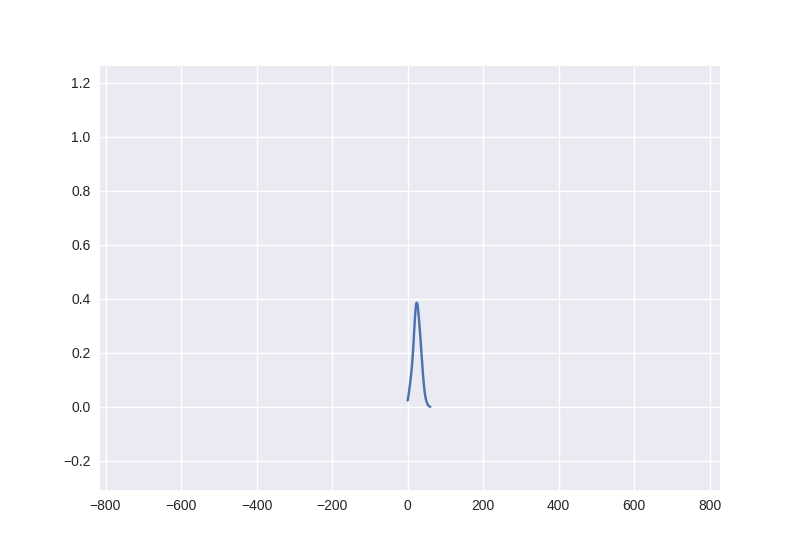

In [55]:
plt.plot(np.convolve(snip,snip)[len(snip)/2:])
(snip+1).plot()

In [59]:
# plt.plot(np.convolve(dfsmoo+1,snip)[len(snip)/2:])
plt.plot((np.convolve(dfsmoo,snip)[len(snip)/2:])/2)
dfsmoo.plot()
(snip+1).plot()

In [85]:
head=dfsmoo.cumsum().values

In [82]:
(head.values.shape)

(81954,)

In [83]:
len(head.values[:-10])

81944

<IPython.core.display.Javascript object>


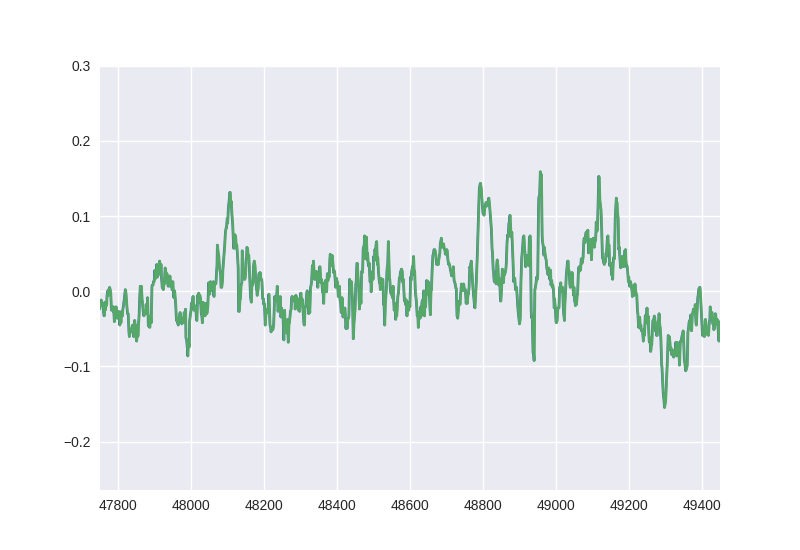

In [95]:
win=1
plt.plot((head[win:]-head[:-win]))
dfsmoo.plot()

In [104]:
(df.trajectory__case.unique())

array([0., 1., 2., 3.])

<IPython.core.display.Javascript object>


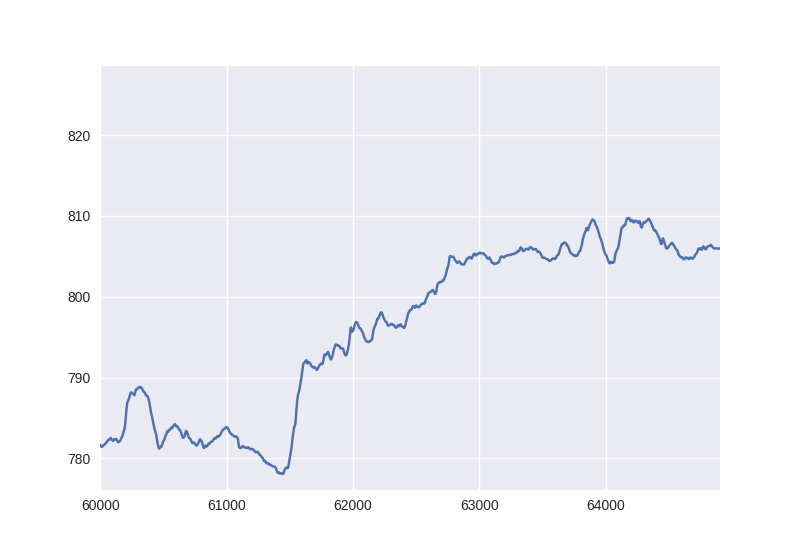

In [96]:
# dfsmoo.plot()
(dfsmoo.cumsum()).plot()

'grassSky'

In [19]:
'/'.join(a[0].split('/')[-4:])

'grassSky/direct/0.5/2018-01-17__14~43~47_apple69_00_wind_gain~8_speed~1.0_bout~15_DC~-0.02_traj.bag.dfpickle'

In [25]:
tic()
dfl2=[]
for i, filepath in enumerate( a):
#     df=pickle2df(filepath)[0]
    try:
        df=pd.read_hdf('.'.join(filepath.split('.')[0:-1])+'.h5')
        fnjson='.'.join(a[0].split('.')[:-2])+'.json'
        with open(fnjson) as f:
            parameters=json.load(f)
        df.parameters=parameters
        
        windPressure=filepath.split('/')[-2:-1][0]
        visual=filepath.split('/')[-4:-3][0]
        flowSource=filepath.split('/')[-3:-2][0]
        
        df['windPressure']=windPressure
        df['visual']=visual
        df['flowSource']=flowSource
        
        timestamp='_'.join(filepath.split('/')[-1].split('_')[:3])
        dfl2.append(df)
            
#         dfl2.append(df)
    except IOError:
        print ('some io error at'), filepath
    print "Reading file {0} of {1}".format(i,len(a))
toc()    
b=pd.concat(dfl2)

Reading file 0 of 43
Reading file 1 of 43
Reading file 2 of 43
Reading file 3 of 43
Reading file 4 of 43
Reading file 5 of 43
Reading file 6 of 43
Reading file 7 of 43
Reading file 8 of 43
Reading file 9 of 43
Reading file 10 of 43
Reading file 11 of 43
Reading file 12 of 43
Reading file 13 of 43
Reading file 14 of 43
Reading file 15 of 43
Reading file 16 of 43
Reading file 17 of 43
Reading file 18 of 43
Reading file 19 of 43
Reading file 20 of 43
Reading file 21 of 43
Reading file 22 of 43
Reading file 23 of 43
Reading file 24 of 43
Reading file 25 of 43
Reading file 26 of 43
Reading file 27 of 43
Reading file 28 of 43
Reading file 29 of 43
Reading file 30 of 43
Reading file 31 of 43
Reading file 32 of 43
Reading file 33 of 43
Reading file 34 of 43
Reading file 35 of 43
Reading file 36 of 43
Reading file 37 of 43
Reading file 38 of 43
Reading file 39 of 43
Reading file 40 of 43
Reading file 41 of 43
Reading file 42 of 43
Elapsed time: 14.051697 seconds.



In [28]:
b.windPressure.unique()

array(['0.5', '0', '1.5', '1', '2.5', '2', '3.5', '3', '4.5', '4.8', '4'], dtype=object)

In [11]:
bokehQuadPlot(b,parameters['parameters'],showPlot=True)

(Column(id='3fa17f83-9542-4a56-98d0-0f9a7c4e7580', ...),
 None,
 None,
 None,
 None)

In [30]:
b.groupby(by=['flowSource','windPressure','visual'],as_index=False)

In [ ]:
df=Out[56]
df=df[0]

In [ ]:
xc=514
yc=513
w=15
xw=w
yw=w
xr=(xc-xw,xc+xw)
yr=(yc-yw,yc+yw)

# pickleDir2bokeh(addBigTit=False,addSmallTit=False,addArrow=False,
#                 addStart=False,x_range=xr,y_range=yr,
#                 defaultPath='/media/rhagoletis/6db8b2b2-ebe2-4555-9b79-93b10ef9dec31/agg/odour+wind/')
out=plotAggreg(x_range=xr,y_range=yr)

In [ ]:
a=pickle2df('/home/rhagoletis/catkin/src/World/bags/2017-09-03__17~46~56_apple55_00_odour_wind_gain~16_speed~1.0_bout~30_DC~0.0_traj.bag_df.pickle')
df=a[0]

In [ ]:
df['run']=((df.trajectory__runNum-1)*4+df.trajectory__trial)

In [ ]:
df3=df[df.run==4]

In [ ]:
fps=165
preE=2
postE=2
preE*=fps
postE*=fps


In [ ]:
df3=df[df.run==4*i]
offI=np.where(df3.trajectory__valve1.diff()==-1)
# offI[0]=np.append(offI[0],len(df3)-1)
offI=np.append(offI[0],len(df3)-1)

offInterval=np.diff(offI)
offInterval=np.append(offInterval,0)
print offI,len(offI)
print offInterval,len(offInterval)

xcoords=offI[offInterval>preE]
xcoordsI=df3.index[xcoords]


for xc in xcoords:
    sx=df3.trajectory__pPos_x[xc]
    sy=df3.trajectory__pPos_y[xc]
    sh=df3.trajectory__pOri_x[xc]
    
    x=df3.trajectory__pPos_x-sx
    y=df3.trajectory__pPos_y-sy
    
    xp=x*np.cos(np.deg2rad(sh))-y*np.sin(np.deg2rad(sh))
    yp=x*np.sin(np.deg2rad(sh))+y*np.cos(np.deg2rad(sh))

    
    plt.scatter(x=xp[xc-preE:xc],
                y=yp[xc-preE:xc],alpha=0.4,s=0.5)
    plt.scatter(x=xp[xc:xc+postE],
                y=yp[xc:xc+postE],alpha=1,s=2)

#     plt.scatter(x=df3.trajectory__pPos_x[xc-preE:xc]-sx,
#                 y=df3.trajectory__pPos_y[xc-preE:xc]-sy,alpha=0.4,s=0.5)
#     plt.scatter(x=df3.trajectory__pPos_x[xc:xc+postE]-sx,
#                 y=df3.trajectory__pPos_y[xc:xc+postE]-sy,alpha=1,s=2)

#     df3.trajectory__pPos_x[xc-preE:xc+postE].plot()
# for xc in xcoordsI:
#     plt.axvline(x=xc)

    
# df3.trajectory__valve1.plot()
plt.show()

In [ ]:
i=1
print i
df3=df[df.run==4*i]
offI=np.where(df3.trajectory__valve1.diff()==-1)
# offI[0]=np.append(offI[0],len(df3)-1)
offI=np.append(offI[0],len(df3)-1)

offInterval=np.diff(offI)
offInterval=np.append(offInterval,0)
print offI,len(offI)
print offInterval,len(offInterval)

xcoords=offI[offInterval>preE]
xcoordsI=df3.index[xcoords]


for xc in xcoords:
    sx=df3.trajectory__pPos_x[xc]
    sy=df3.trajectory__pPos_y[xc]
    sh=-(df3.trajectory__pOri_x[xc])
    print sh
    
    x=df3.trajectory__pPos_x-sx
    y=df3.trajectory__pPos_y-sy
    h=df3.trajectory__pOri_x

#     xp=x
#     yp=y
#     plt.scatter(x=xp[xc-preE:xc],
#                 y=yp[xc-preE:xc],alpha=0.4,s=.5)
#     plt.scatter(x=xp[xc:xc+postE],
#                 y=yp[xc:xc+postE],alpha=1,s=.10)
    
    xp=x*np.cos(np.deg2rad(sh))-y*np.sin(np.deg2rad(sh))
    yp=x*np.sin(np.deg2rad(sh))+y*np.cos(np.deg2rad(sh))

    print 
    plt.scatter(x=xp[xc-preE:xc],
                y=yp[xc-preE:xc],alpha=0.4,s=2)
    plt.scatter(x=xp[xc:xc+postE],
                y=yp[xc:xc+postE],alpha=1,s=10)

plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [1]:
fps=165
preT=2
preE=3
postE=3
preE*=fps
postE*=fps
preT*=fps

for i in df.run.unique():
    print i
    df3=df[df.run==4*i]
    offI=np.where(df3.trajectory__valve1.diff()==-1)
    # offI[0]=np.append(offI[0],len(df3)-1)
    offI=np.append(offI[0],len(df3)-1)

    offInterval=np.diff(offI)
    offInterval=np.append(offInterval,0)
    print offI,len(offI)
    print offInterval,len(offInterval)

    xcoords=offI[offInterval>preT]
    xcoordsI=df3.index[xcoords]


    for xc in xcoords:
        sx=df3.trajectory__pPos_x[xc]
        sy=df3.trajectory__pPos_y[xc]
        sh=-(df3.trajectory__pOri_x[xc])
        sh=0
        print sh

        x=df3.trajectory__pPos_x-sx
        y=df3.trajectory__pPos_y-sy
        h=df3.trajectory__pOri_x

    #     xp=x
    #     yp=y
    #     plt.scatter(x=xp[xc-preE:xc],
    #                 y=yp[xc-preE:xc],alpha=0.4,s=.5)
    #     plt.scatter(x=xp[xc:xc+postE],
    #                 y=yp[xc:xc+postE],alpha=1,s=.10)

        xp=x*np.cos(np.deg2rad(sh))-y*np.sin(np.deg2rad(sh))
        yp=x*np.sin(np.deg2rad(sh))+y*np.cos(np.deg2rad(sh))

        print 
        plt.scatter(x=xp[xc-preE:xc],
                    y=yp[xc-preE:xc],alpha=0.2,s=10,c='r')
        plt.scatter(x=xp[xc:xc+postE],
                    y=yp[xc:xc+postE],alpha=0.2,s=10,c='g')

plt.axes().set_aspect('equal', 'datalim')
plt.show()

NameError: name 'df' is not defined

In [ ]:
plt.scatter(x=df3.trajectory__pPos_x,y=df3.trajectory__pPos_y)
plt.show()

In [ ]:
df3.index[offI[offInterval>preE]]

In [ ]:
xcoords=df3.index[offI[offInterval>preE]]

In [ ]:
offI[0][offInterval>preE]

In [ ]:
df3.trajectory__pPos_x.plot()


In [ ]:
df3.trajectory__pPos_x[xcoords[0]:]


In [ ]:
np.where(df3.trajectory__valve1.diff()==-1)`
df3.trajectory__valve1.plot()
plt.show()

In [ ]:
df3.trajectory__valve1.plot()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
# %pylab inline


a=pickle2df()
df=a[0]


x=df.trajectory__pPos_x.values
y=df.trajectory__pPos_y.values


f=30000
l=f+10000
dft=df.ix[f:l]
x_=x[f:l]
y_=y[f:l]

In [ ]:
parameters=a[1]

In [ ]:

class PlotData():
    def __init__(self,df,parameters, fig=None,
              x_range=None, y_range=None,
              plot_width=1000, plot_height=1000,
              xc=513, yc=505, xw=20, yw=20,
              showPlot=True, title=None, addOdour=True,
              addStart=True, addArrow=True,reallign=False,xir=513,yir=513,
                 plotFrom=None,plotTo=None,
                 runNumFrom=None,runNumTo=None,
                 caseFrom=None,caseTo=None,filterGui=False

                 ):

        self.df=df
        # self.case=case
        self.parameters=parameters
        self.fig=fig
        self.plot_width=plot_width
        self.plot_height=plot_height
        self.x_range=self.getRange(x_range, xc, xw)
        self.y_range=self.getRange(y_range, yc, yw)

        self.showPlot=showPlot
        self.title=title

        self.df2,self.plotFrom,self.plotTo=self.filterData(
                                            self.df,runNumFrom,runNumTo,
                                            caseFrom,caseTo,
                                            plotFrom,plotTo,
                                            reallign,xir,yir,
                                            filterGui)

        return self.df2

    def filterData(self,df, runNumFrom,runNumTo,
                    caseFrom,caseTo,plotFrom,plotTo,
                    reallign,xir,yir,
                   filterGui=True):

        if filterGui:
            msg = "Enter the start stop of your data"
            title = "Choose runNum/case or explicit index"
            fieldNames = ["runNumFrom", "runNumTo", "caseFrom", "caseTo", "IndexFrom", "IndexTo"]
            fieldValues = multenterbox(msg, title, fieldNames)

            runNumFrom=fieldValues[0]
            runNumTo=fieldValues[1]
            caseFrom=fieldValues[2]
            caseTo=fieldValues[3]
            plotFrom=fieldValues[4]
            plotTo=fieldValues[5]


        if plotFrom is 'start':
            plotFrom=0
        elif (filterGui and plotFrom=='') or (not filterGui and plotFrom is None):
            plotFrom = np.where((df["trajectory__runNum"] == runNumFrom) &
                              (df["trajectory__case"] == caseFrom))[0][0]


        if plotTo is 'end':
            plotTo = df.shape[0]
        elif (filterGui and plotTo=='') or (not filterGui and plotTo is None):
            plotTo = np.where((df["trajectory__runNum"] == runNumTo) &
                              (df["trajectory__case"] == caseTo))[0][0]




        if reallign:
            xs = self.parameters['playerInitPos'][0]
            ys = self.parameters['playerInitPos'][1]

            xoffs = xs - xir
            yoffs = ys - yir
            self.parameters['playerInitPos'][0]-=xoffs
            self.parameters['playerInitPos'][1]-=yoffs


            df.trajectory__pPos_x-=xoffs
            df.trajectory__pPos_y-=yoffs

        return df.ix[plotFrom:plotTo,:],plotFrom,plotTo

    def getRange(self, range, c, w):
        '''
        give the range if range is none as center +- width
        :param range: a tuple containing range, None if need to defined by center and width
        :param c: Center of the range
        :param w: Total width of the range 
        :return: range tuple centered around c, with width w
        '''
        if range is None:
            range=(c-w/2.,c+w/2.)

        return range



class BokehPlot(PlotData):
    def __init__(self,case,TOOLS="pan,crosshair,wheel_zoom\
                ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
                output_backend="webgl",addSmallTit=True,titFontSize='14pt',
                addTraj=True,addOdour=True,addStart=True,addArrow=True,
                trajS=4,odourS=8,startS=10,arrowS=20,
                trajAlpha=0.5,odourAlpha=0.8,startAlpha=0.9,arrowAlpha=0.8,
                trajC='blue',odourC='green',startC='red',arrowC='black'):

        self.df=super(PlotData, self).__init__()

        dfc = self.df[self.df.trajectory__case == case]
        x = dfc.trajectory__pPos_x
        y = dfc.trajectory__pPos_y
        h = np.deg2rad(dfc.trajectory__pOri_x)

        if 'haw' in self.parameters['fly']:
            dfcv = dfc.trajectory__valve2
        elif 'apple' in self.parameters['fly']:
            dfcv = dfc.trajectory__valve1

        ox = dfc[dfcv == True].trajectory__pPos_x
        oy = dfc[dfcv == True].trajectory__pPos_y


        try:
            cm = bp.viridis(max(self.parameters['odourQuad']) + 1)
            fc = cm[self.parameters["odourQuad"][case]]
        except TypeError:
            fc = bp.viridis(10)[5]

        if not addSmallTit:
            title = ''

        if self.fig is None:
            self.fig = figure(tools=TOOLS, x_range=self.x_range, y_range=self.y_range,
                         plot_width=self.plot_width, plot_height=self.plot_height,
                         active_scroll='wheel_zoom', title=title,
                         output_backend=output_backend,)

        self.fig.title.align = 'center'
        self.fig.title.text_font_size = titFontSize

        r = 2
        xs = self.parameters['playerInitPos'][0]
        ys = self.parameters['playerInitPos'][1] 
        # if reallign:
        #     xoffs = xs - 513
        #     yoffs = ys - 513
        # else:
        #     xoffs = 0
        #     yoffs = 0

        # Pos and heading of fly
        if addTraj:
            self.fig.triangle(x, y, size=trajS, angle=h, 
                              fill_alpha=trajAlpha, line_color=None,fill_color=trajC)

        if addOdour:
            # circle at odour pos, with pf encoded in color
            self.fig.circle(ox, oy, size=odourS, fill_alpha=odourAlpha, line_color=None, 
                            fill_color=odourC)

        if addStart:
            # triangle at init pos
            self.fig.triangle(xs,ys,
                         size=startS, angle=self.parameters['playerInitH'], 
                              fill_alpha=startAlpha, line_color=None, color=startC)

        # arrow

        if self.parameters["windQuad"][case] == -3:
            lw = 0
            la = 0.1
        elif self.parameters["windQuad"][case] == -2:
            lw = 4
            la = 1
        else:
            lw = 10
            la = 1
        # print 'le is',lw
        theta = self.parameters['windQuadOpen'][case] + 180

        if addArrow:
            self.fig.add_layout(Arrow(end=VeeHead(size=arrowS), line_color=arrowC, 
                                    line_alpha=la,line_width=lw,
                                    x_start=xs, y_start=ys, 
                                    x_end=xs + r * np.cos(np.deg2rad(theta)), 
                                    y_end=ys + r * np.sin(np.deg2rad(theta))))

        return self.fig
    


In [ ]:
BokehPlot(df=df,parameters=parameters,case=1)

In [ ]:
df=a[0]
reset=np.where(df["trajectory__reset"] == True)[0]
print reset

In [ ]:
import arrow

In [ ]:
import easygui
import arrow

bagPath='/home/rhagoletis/catkin/src/World/bags/2017-09-03__17~46~56_apple55_00_odour_wind_gain~16_speed~1.0_bout~30_DC~0.0_full.bag'
runNumStart=12
caseStart=2

# bagPath=easygui.fileopenbox(filetypes=['*.bag'])
# runNumStart=easygui.integerbox(msg='wnter the start runNum')
# caseStart=easygui.integerbox(msg='enter the start case')

# runNumStop=easygui.integerbox(msg='wnter the stop runNum')
# caseStop=easygui.integerbox(msg='enter the start case')

pklP='/home/rhagoletis/catkin/src/World/bags/2017-09-03__17~46~56_apple55_00_odour_wind_gain~16_speed~1.0_bout~30_DC~0.0_full.bag_df.pickle'
df,parameters,path=pickle2df(path=pklP)


In [ ]:
df.trajectory__DCoffset[100:103]

In [ ]:
plt.scatter(x=df.trajectory__pPos_x[232743:],y=df.trajectory__pPos_y[232743:])
plt.show()

In [ ]:
reset=np.where(df["trajectory__reset"] == True)[0]
reset

In [ ]:
startI=np.where((df["trajectory__runNum"]==runNumStart)&(df["trajectory__case"]==caseStart))[0][0]
print startI
dt=df.index[startI]

In [ ]:
df.ix[2:,:]

In [ ]:
save(bokehPlot(df,3,parameters,title=''),path+'_3TrajOver.html')
save(bokehPlot(df,3,parameters,title='',addOdour=False),path+'_3Traj.html')
save(bokehPlot(df.ix[startI:,:],3,parameters,title=''),path+'_3SelTrajOver.html')
save(bokehPlot(df.ix[startI:,:],3,parameters,title='',addOdour=False),path+'_3SelTraj.html')

# startI

In [ ]:
from easygui import multenterbox
msg = "Enter the start stop of your data"
title = "Choose runNum/case or explicit index"
fieldNames = ["runNumFrom","runNumTo","caseFrom","caseTo","IndexFrom","IndexTo"]
fieldValues = []  # we start with blanks for the values
fieldValues = multenterbox(msg,title, fieldNames)

# ma